In [47]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import os

In [48]:
matrix = pd.read_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/featureMatrix/2_full_matrix_any_occurrence.csv', index_col=0)
y_data = matrix[['BDSPPatientID', 'NoteTitle', 'annot']]
X = matrix.drop(columns=['BDSPPatientID', 'NoteDate', 'NoteTitle', 'text', 'hospital', 'annot'])
X.head()

,ICD,headach,doubl vision,diplopia,sudden,neck pain,nausea,vomit,dizzi,photophobia,...,neg_trauma,neg_alter mental status,neg_am,neg_ivh,neg_parenchym hemorrhag,neg_intraventricular hemorrhag,neg_subdur,neg_tbi,neg_confus,neg_syncop
0,1,1,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,1,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0
4,1,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [49]:
y = y_data['annot']
y.head()

0    0
1    1
2    0
3    1
4    0
Name: annot, dtype: int64

In [50]:
all_predictions = []
all_true_labels = []
all_row_numbers = []

# outer loop
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
final_Cs = []
final_l1 = []
predictions = []
roc_curves = []
pr_curves = []

# Dictionary to store patient IDs for each fold
fold_patient_ids = {f'fold_{i+1}': {'train': [], 'test': []} for i in range(10)}

# Dictionary to store feature importances
feature_importances_dict = {feature: [] for feature in X.columns}

# Initialize KFold
kf = KFold(n_splits=10)

for fold_idx, (train_index, test_index) in enumerate(kf.split(X,y)):
    fold_name = f'fold_{fold_idx + 1}'
    fold_patient_ids[fold_name]['train'] = y_data.iloc[train_index]['BDSPPatientID'].tolist()
    fold_patient_ids[fold_name]['test'] = y_data.iloc[test_index]['BDSPPatientID'].tolist()


    Xtr, Xte = X.loc[train_index], X.loc[test_index]
    ytr, yte = y.loc[train_index], y.loc[test_index]

   
    model = LogisticRegression(
            penalty='elasticnet',
            class_weight=None, random_state=2024,
            solver='saga', max_iter=10000)
   
    search_spaces = {
         'C': (1e-3, 1e+3, 'log-uniform'),
         'l1_ratio': (0.01, 0.99),
    }
    model_cv = BayesSearchCV(model,
            search_spaces,
            n_iter=50, scoring='roc_auc', n_jobs=-1,
            cv=5, random_state=2024)
    
    model_cv.fit(Xtr, ytr)

    #Find the Best hyperparameters and append them
    best_hparams = model_cv.best_params_
    best_C = best_hparams['C']
    best_l1_ratio = best_hparams['l1_ratio']
    final_Cs.append(best_C)
    final_l1.append(best_l1_ratio)

    model = model_cv.best_estimator_

    ytr_pred = model.predict_proba(Xtr)[:,1]      # Xtr is training features, ytr is training labels, ytr_pred is training predictions = Prob(y=1|Xtr)
    yte_pred = model.predict_proba(Xte)[:,1]    # Xte is testing features

    fpr, tpr, cutoffs = roc_curve(ytr, ytr_pred)
    best_cutoff = cutoffs[np.argmax(tpr - fpr)]
    yte_pred_bin =(yte_pred>best_cutoff).astype(int)
    auc_cv.append(roc_auc_score(yte, yte_pred))
    f1_cv.append( f1_score(yte, yte_pred_bin) )
    cf_cv.append( confusion_matrix(yte, yte_pred_bin) )
    predictions.append(yte_pred_bin)

    fpr, tpr, cutoffs = roc_curve(yte, yte_pred)

    # Store the predictions and true labels for this fold
    all_predictions.extend(yte_pred_bin)
    all_true_labels.extend(yte)
    all_row_numbers.extend(y_data.iloc[test_index]['BDSPPatientID'])

    # Save info for the plots
    roc_curves.append((fpr, tpr, roc_auc_score(yte, yte_pred)))
    precision, recall, thresholds = precision_recall_curve(yte, yte_pred)
    pr_curves.append((recall, precision, auc(recall, precision)))
    auc_pr_loop = auc(recall, precision)
    auc_pr.append(auc_pr_loop)

    # Extract feature importances (coefficients)
    feature_importances = model.coef_[0]
    for feature, importance in zip(X.columns, feature_importances):
        feature_importances_dict[feature].append(importance)

    print("Feature importances for this fold:")
    print(pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False))

    print(auc_cv)
    print(auc_pr)


fold_patient_ids_list = []
for fold, ids in fold_patient_ids.items():
    for train_id in ids['train']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'train', 'patient_id': train_id})
    for test_id in ids['test']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'test', 'patient_id': test_id})

fold_patient_ids_df = pd.DataFrame(fold_patient_ids_list)
fold_patient_ids_df.to_csv('new_LR_fold_patient_ids.csv', index=False)

Feature importances for this fold:
          Feature  Importance
65            sah    1.945012
73   subarachnoid    0.979481
81      nimodipin    0.725976
38          angio    0.676317
0             ICD    0.551754
..            ...         ...
178        neg_av   -0.450638
25           numb   -0.452824
101        strike   -0.598028
104        trauma   -0.631264
99        fractur   -0.912816

[202 rows x 2 columns]
[0.9946018893387315]
[0.9814078691001024]
Feature importances for this fold:
          Feature  Importance
65            sah    2.010445
73   subarachnoid    1.079901
81      nimodipin    0.827913
0             ICD    0.644653
57      vasospasm    0.644435
..            ...         ...
8           dizzi   -0.411049
94          accid   -0.429982
101        strike   -0.503794
104        trauma   -0.540327
99        fractur   -1.010197

[202 rows x 2 columns]
[0.9946018893387315, 0.9624947324062368]
[0.9814078691001024, 0.9102891253523588]
Feature importances for this fold:
   

In [51]:
print(np.mean(auc_cv))
print(np.mean(auc_pr))


0.9741192412940982
0.9324407774282368


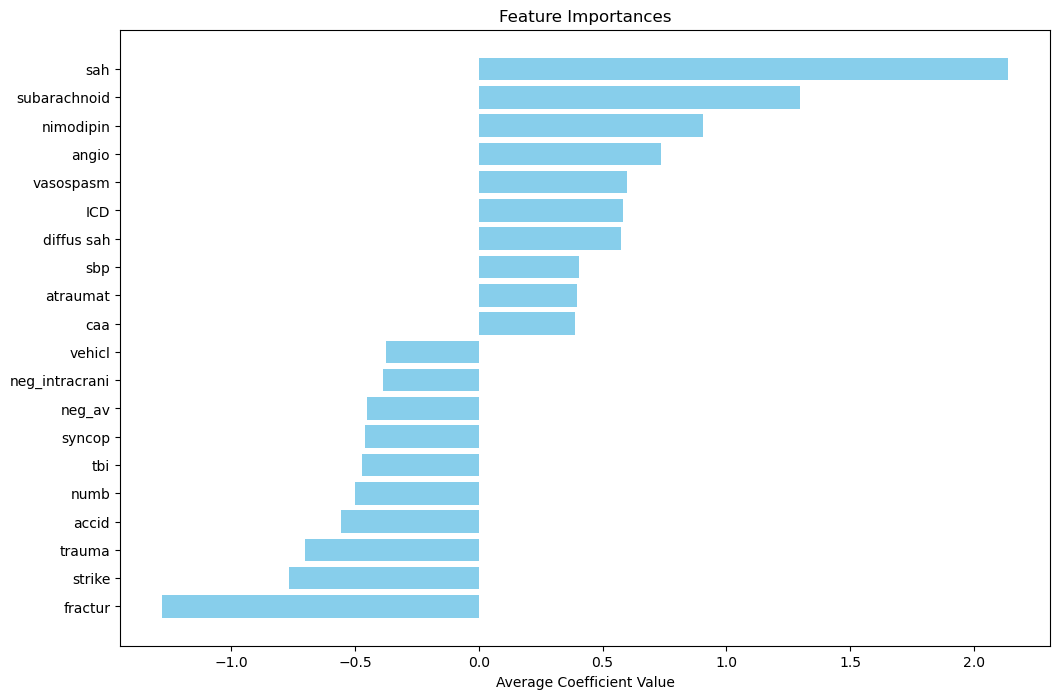

In [52]:
# Aggregate feature importances by averaging over folds
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Define the output directory
output_dir = '/home/jsearle/bigDrive/NAX/NLP-SAH_identification/trainModels/results/LogReg'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the DataFrame to a CSV file
csv_file_path = os.path.join(output_dir, 'feat_importances.csv')
feature_importance_df.to_csv(csv_file_path, index=False)

# Select top 10 and bottom 10 features
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

# Combine top and bottom features for plotting
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top

# Save the plot to a PNG file
plt.savefig(os.path.join(output_dir, 'feat_importances.png'))
plt.show()



In [53]:
# Initialize lists to store false positives and false negatives
false_positives = []
false_negatives = []

# Iterate through the combined lists
for pred, true, pid in zip(all_predictions, all_true_labels, all_row_numbers):
    if pred == 1 and true == 0:
        false_positives.append(pid)
    elif pred == 0 and true == 1:
        false_negatives.append(pid)

# Convert the lists to DataFrames for easier access and analysis
false_positives_df = pd.DataFrame(false_positives, columns=['BDSPPatientID'])
false_negatives_df = pd.DataFrame(false_negatives, columns=['BDSPPatientID'])

# Save the DataFrames to CSV files
FP_file_path = os.path.join(output_dir, 'false_positives.csv')
FN_file_path = os.path.join(output_dir, 'false_negatives.csv')
false_positives_df.to_csv(FP_file_path, index=False)
false_negatives_df.to_csv(FN_file_path, index=False)

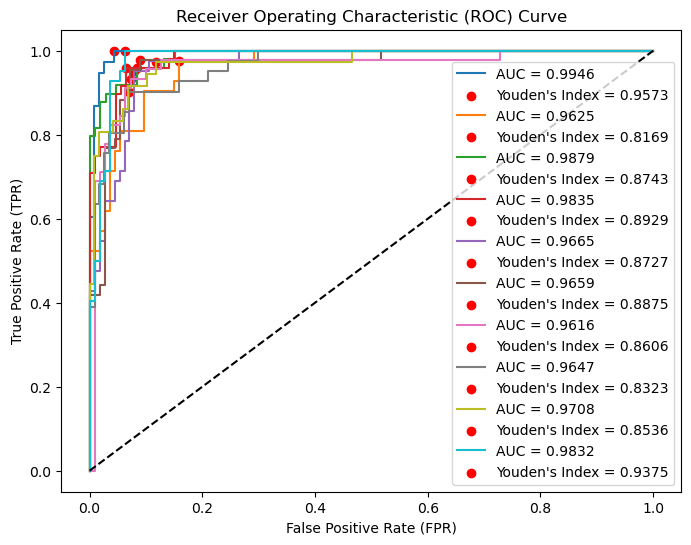

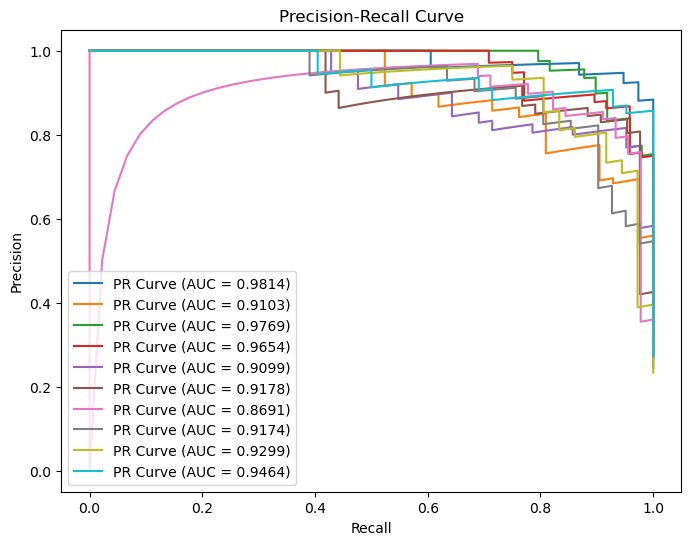

0.9741192412940982
0.8715362610529184


In [54]:
# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
    youden = np.max(tpr-fpr)
    plt.scatter(fpr[np.argmax(tpr-fpr)], tpr[np.argmax(tpr-fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(os.path.join(output_dir, 'AUC_iter.png'))
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig(os.path.join(output_dir, 'PR_iter.png'))
plt.show()


# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv(os.path.join(output_dir, 'LR_iter_pred_rr.csv'), index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df['C'] = final_Cs
df['l1_ratio'] = final_l1
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
df3 = pd.DataFrame(predictions[2])
df4 = pd.DataFrame(predictions[3])
df5 = pd.DataFrame(predictions[4])
df_pred = pd.concat([df1,df2,df3,df4,df5]).reset_index()
df.to_csv(os.path.join(output_dir, 'LR_iter.csv'))

# Print final Data
print(auc_final)
print(f1_final)

In [55]:
print(final_Cs)
print(final_l1)

[0.1400224502803669, 0.14166809328430577, 0.1659726848307, 0.15819015139360176, 0.20641281704157138, 0.2571099039329649, 0.3116111179393675, 0.2505596877298371, 0.31435013547244667, 0.31242141073891316]
[0.12198728114013357, 0.29233408887783147, 0.3270273189585856, 0.32618892202405136, 0.32202122261474764, 0.7498724320033978, 0.4856175122564875, 0.2854034328372258, 0.38077483719072835, 0.45827877061676775]


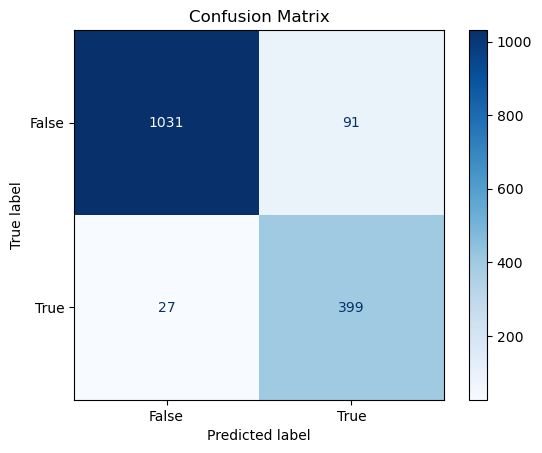

[[1031   91]
 [  27  399]]


In [56]:
# Create the confusion matrix
cf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=[False, True])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig(os.path.join(output_dir, 'cf_matrix.png'))
plt.show()

# Print the confusion matrix
print(cf_matrix)

In [57]:
def calculate_metrics(cf_matrix):
    TN, FP, FN, TP = cf_matrix.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1
# Calculate metrics for each fold
for fold_index, cf_matrix in enumerate(cf_cv):
    accuracy, precision, recall, f1 = calculate_metrics(cf_matrix)
    print(f"Metrics for Fold {fold_index + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")
# Calculate overall metrics
overall_cf_matrix = np.sum(cf_cv, axis=0)
overall_accuracy, overall_precision, overall_recall, overall_f1 = calculate_metrics(overall_cf_matrix)
print("Overall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")

Metrics for Fold 1:
Accuracy: 0.9742
Precision: 0.9250
Recall: 0.9737
F1 Score: 0.9487

Metrics for Fold 2:
Accuracy: 0.8903
Precision: 0.7451
Recall: 0.9048
F1 Score: 0.8172

Metrics for Fold 3:
Accuracy: 0.9226
Precision: 0.8364
Recall: 0.9388
F1 Score: 0.8846

Metrics for Fold 4:
Accuracy: 0.9355
Precision: 0.8654
Recall: 0.9375
F1 Score: 0.9000

Metrics for Fold 5:
Accuracy: 0.9161
Precision: 0.7736
Recall: 0.9762
F1 Score: 0.8632

Metrics for Fold 6:
Accuracy: 0.9290
Precision: 0.8478
Recall: 0.9070
F1 Score: 0.8764

Metrics for Fold 7:
Accuracy: 0.9097
Precision: 0.7818
Recall: 0.9556
F1 Score: 0.8600

Metrics for Fold 8:
Accuracy: 0.8839
Precision: 0.7255
Recall: 0.9024
F1 Score: 0.8043

Metrics for Fold 9:
Accuracy: 0.9221
Precision: 0.8158
Recall: 0.8611
F1 Score: 0.8378

Metrics for Fold 10:
Accuracy: 0.9545
Precision: 0.8571
Recall: 1.0000
F1 Score: 0.9231

Overall Metrics:
Accuracy: 0.9238
Precision: 0.8143
Recall: 0.9366
F1 Score: 0.8712
